# Como construir um sistema de recomendação para dados de compra (passo a passo)
* Descrição: uma documentação sobre a construção de modelos de filtragem colaborativa para recomendar produtos aos clientes
* Link: https://medium.com/datadriveninvestor/how-to-build-a-recommendation-system-for-purchase-data-step-by-step-d6d7a78800b6
* Autor: Moorissa Tjokro

## Declaração do problema
Iremos construir modelos de filtragem colaborativa para recomendar itens de produtos. As etapas a seguir têm como objetivo recomendar aos usuários seus 10 principais itens para colocar na cesta. A saída final será um arquivo csv na pasta `output` 

Usaremos dados de vendas de produtos de um ótica.

Serão gerados dois modelos:  Um para os clientes que nunca compraram e outro para os clientes que já fizeram alguma compra


##Importação das bibliotecas  necessárias


In [ ]:
!pip install turicreate

In [2]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import turicreate as tc
from sklearn.model_selection import train_test_split
import seaborn as sns



##Carregando os dados
Os dados se referem a compra de produtos por cada cliente, sendo que alguns clientes nunca compraram e outros compraram um ou mais item

In [3]:
names=pd.read_csv('/content/ProdutoComVenda_Abr2019_Abr2021_OC.csv',sep=';')

df=pd.read_csv('/content/VendaClienteProduto_Abr2020_Abr2021_OC.csv',sep=';',
                  names=['customerId','productId','purchase_count'], header=None)
df=df.fillna(0)
df=df.apply(np.int64)
data_original=df.copy()

data=df.loc[df['purchase_count'] !=0 ]
data=data.groupby(['customerId','productId'],as_index=False).sum()
data=data.rename(columns={'userId':'customerId','counts':'purchase_count'})
users_to_recommend_sim = list(data['customerId'])

data2 = df.loc[df['purchase_count']==0]
users_to_recommend_pop = list(data2['customerId'])





##Os dados foram agregados acima, resumindo os totais de produtos comprados pelos clientes.

##Foram divididos em dois dataframes: Um com os clientes que nunca compraram e outro com os clientes que já compraram um ou mais itens

In [4]:
data


,customerId,productId,purchase_count
0,1,81572,1
1,2,81572,3
2,29,81065,1
3,29,81730,1
4,29,83484,1
...,...,...,...
42212,212890,88947,1
42213,212892,87165,1
42214,212893,103133,1
42215,212897,97411,1


In [5]:
data2

,customerId,productId,purchase_count
0,254,0,0
1,3372,0,0
2,203854,0,0
3,203998,0,0
4,203999,0,0
...,...,...,...
192722,105331,0,0
192723,174220,0,0
192724,164968,0,0
192725,162245,0,0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(0.0, 3.0)

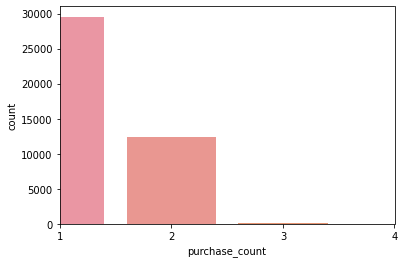

In [6]:
sns.countplot(data['purchase_count'])
plt.xlim(0,3)

4. Divida o conjunto de dados em treino e teste
* Dividir os dados em conjuntos de treinamento e teste é uma parte importante da avaliação da modelagem preditiva, neste caso, um modelo de filtragem colaborativa. Normalmente, usamos uma parte maior dos dados para treinamento e uma parte menor para teste.
* Usamos a proporção 80:20 para o tamanho do nosso conjunto de treino e teste.
* Nossa parte de treinamento será usada para desenvolver um modelo preditivo, enquanto a outra para avaliar o desempenho do modelo.


In [7]:
train, test = train_test_split(data, test_size = .2)
print(train.shape, test.shape)

(33773, 3) (8444, 3)


##Os dados serão convertidos no formato SFrame, que é o formato utilizado pela biblioteca TuriCreate

In [8]:
train.dtypes

customerId        int64
productId         int64
purchase_count    int64
dtype: object

In [9]:


train_data = tc.SFrame(train)
test_data = tc.SFrame(test)

In [10]:
train_data

customerId,productId,purchase_count
204212,76319,1
209147,75694,2
208147,99845,1
212271,97535,2
3111,65284,1
859,87673,1
207496,81368,1
4829,81289,2
100906,81572,1
209365,87965,1


In [11]:
test_data

customerId,productId,purchase_count
2364,88757,1
180569,94825,1
5219,79781,1
208494,58398,1
211991,42693,2
208986,59758,1
158161,83761,1
206610,84758,1
211533,64430,1
903,87662,1


##Modelo Popularidade - Dados Mais vendidos por todos clientes
O modelo de popularidade usa os itens mais populares para recomendação. Esses itens são produtos com o maior número de vendas entre os clientes.



In [12]:
# variables to define field names
user_id = 'customerId'
item_id = 'productId'
target = 'purchase_count'
#users_to_recommend = list(userId)
n_rec = 10 # number of items to recommend
n_display = 30

In [13]:
pop = tc.popularity_recommender.create(train_data, 
                                                    user_id=user_id, 
                                                    item_id=item_id, 
                                                    target=target)

Preparing data set.

Data has 33773 observations with 17959 users and 9932 items.

Data prepared in: 0.084508s

33773 observations to process; with 9932 unique items.

##Obtemos abaixo a recomendação para os clientes sendo 30 linhas principais / principais para os 3 primeiros clientes com 10 recomendações cada

In [14]:


popularity_recomm = pop.recommend(users=users_to_recommend_pop, k=n_rec)
popularity_recomm.print_rows(n_display)

recommendations finished on 1000/192727 queries. users per second: 10508.7

recommendations finished on 2000/192727 queries. users per second: 11207.5

recommendations finished on 3000/192727 queries. users per second: 11047.4

recommendations finished on 4000/192727 queries. users per second: 10885.7

recommendations finished on 5000/192727 queries. users per second: 10921.7

recommendations finished on 6000/192727 queries. users per second: 10868.6

recommendations finished on 7000/192727 queries. users per second: 10986.7

recommendations finished on 8000/192727 queries. users per second: 10982.7

recommendations finished on 9000/192727 queries. users per second: 11088.8

recommendations finished on 10000/192727 queries. users per second: 11094.5

recommendations finished on 11000/192727 queries. users per second: 11162.3

recommendations finished on 12000/192727 queries. users per second: 10730.1

recommendations finished on 13000/192727 queries. users per second: 10371.3

recommendations finished on 14000/192727 queries. users per second: 10119.6

recommendations finished on 15000/192727 queries. users per second: 9940.48

recommendations finished on 16000/192727 queries. users per second: 9645.91

recommendations finished on 17000/192727 queries. users per second: 9538.2

recommendations finished on 18000/192727 queries. users per second: 9515.01

recommendations finished on 19000/192727 queries. users per second: 9537.4

recommendations finished on 20000/192727 queries. users per second: 9503.84

recommendations finished on 21000/192727 queries. users per second: 9494.34

recommendations finished on 22000/192727 queries. users per second: 9381.48

recommendations finished on 23000/192727 queries. users per second: 9323.16

recommendations finished on 24000/192727 queries. users per second: 9363.39

recommendations finished on 25000/192727 queries. users per second: 9397.65

recommendations finished on 26000/192727 queries. users per second: 9450.59

recommendations finished on 27000/192727 queries. users per second: 9414.51

recommendations finished on 28000/192727 queries. users per second: 9433.42

recommendations finished on 29000/192727 queries. users per second: 9454.08

recommendations finished on 30000/192727 queries. users per second: 9456.86

recommendations finished on 31000/192727 queries. users per second: 9485.26

recommendations finished on 32000/192727 queries. users per second: 9397.28

recommendations finished on 33000/192727 queries. users per second: 9350.53

recommendations finished on 34000/192727 queries. users per second: 9344.74

recommendations finished on 35000/192727 queries. users per second: 9367.27

recommendations finished on 36000/192727 queries. users per second: 9397.05

recommendations finished on 37000/192727 queries. users per second: 9414.52

recommendations finished on 38000/192727 queries. users per second: 9348.88

recommendations finished on 39000/192727 queries. users per second: 9284.63

recommendations finished on 40000/192727 queries. users per second: 9284.5

recommendations finished on 41000/192727 queries. users per second: 9293.23

recommendations finished on 42000/192727 queries. users per second: 9324.04

recommendations finished on 43000/192727 queries. users per second: 9255.08

recommendations finished on 44000/192727 queries. users per second: 9197.34

recommendations finished on 45000/192727 queries. users per second: 9187.43

recommendations finished on 46000/192727 queries. users per second: 9202.52

recommendations finished on 47000/192727 queries. users per second: 9221.21

recommendations finished on 48000/192727 queries. users per second: 9236.32

recommendations finished on 49000/192727 queries. users per second: 9240.46

recommendations finished on 50000/192727 queries. users per second: 9255.75

recommendations finished on 51000/192727 queries. users per second: 9273.64

recommendations finished on 52000/192727 queries. users per second: 9291.73

recommendations finished on 53000/192727 queries. users per second: 9201.97

recommendations finished on 54000/192727 queries. users per second: 9154.54

recommendations finished on 55000/192727 queries. users per second: 9120.42

recommendations finished on 56000/192727 queries. users per second: 9128.04

recommendations finished on 57000/192727 queries. users per second: 9142.38

recommendations finished on 58000/192727 queries. users per second: 9143.25

recommendations finished on 59000/192727 queries. users per second: 9153.44

recommendations finished on 60000/192727 queries. users per second: 9165.36

recommendations finished on 61000/192727 queries. users per second: 9185.06

recommendations finished on 62000/192727 queries. users per second: 9210.83

recommendations finished on 63000/192727 queries. users per second: 9231.09

recommendations finished on 64000/192727 queries. users per second: 9223.78

recommendations finished on 65000/192727 queries. users per second: 9143.84

recommendations finished on 66000/192727 queries. users per second: 9111.8

recommendations finished on 67000/192727 queries. users per second: 9086.08

recommendations finished on 68000/192727 queries. users per second: 9094.8

recommendations finished on 69000/192727 queries. users per second: 9112.57

recommendations finished on 70000/192727 queries. users per second: 9134.59

recommendations finished on 71000/192727 queries. users per second: 9141.5

recommendations finished on 72000/192727 queries. users per second: 9161.96

recommendations finished on 73000/192727 queries. users per second: 9175.67

recommendations finished on 74000/192727 queries. users per second: 9195.24

recommendations finished on 75000/192727 queries. users per second: 9183.76

recommendations finished on 76000/192727 queries. users per second: 9175.02

recommendations finished on 77000/192727 queries. users per second: 9164.9

recommendations finished on 78000/192727 queries. users per second: 9158.95

recommendations finished on 79000/192727 queries. users per second: 9109.71

recommendations finished on 80000/192727 queries. users per second: 9085.6

recommendations finished on 81000/192727 queries. users per second: 9093.34

recommendations finished on 82000/192727 queries. users per second: 9114.21

recommendations finished on 83000/192727 queries. users per second: 9145.81

recommendations finished on 84000/192727 queries. users per second: 9177.51

recommendations finished on 85000/192727 queries. users per second: 9205.01

recommendations finished on 86000/192727 queries. users per second: 9223.23

recommendations finished on 87000/192727 queries. users per second: 9225.09

recommendations finished on 88000/192727 queries. users per second: 9228.57

recommendations finished on 89000/192727 queries. users per second: 9197.57

recommendations finished on 90000/192727 queries. users per second: 9193.67

recommendations finished on 91000/192727 queries. users per second: 9186.43

recommendations finished on 92000/192727 queries. users per second: 9183.05

recommendations finished on 93000/192727 queries. users per second: 9163.96

recommendations finished on 94000/192727 queries. users per second: 9146.75

recommendations finished on 95000/192727 queries. users per second: 9117.18

recommendations finished on 96000/192727 queries. users per second: 9119.57

recommendations finished on 97000/192727 queries. users per second: 9119.44

recommendations finished on 98000/192727 queries. users per second: 9117.83

recommendations finished on 99000/192727 queries. users per second: 9119.38

recommendations finished on 100000/192727 queries. users per second: 9122.46

recommendations finished on 101000/192727 queries. users per second: 9136.88

recommendations finished on 102000/192727 queries. users per second: 9168.33

recommendations finished on 103000/192727 queries. users per second: 9198.47

recommendations finished on 104000/192727 queries. users per second: 9229.5

recommendations finished on 105000/192727 queries. users per second: 9259.85

recommendations finished on 106000/192727 queries. users per second: 9274.28

recommendations finished on 107000/192727 queries. users per second: 9303.81

recommendations finished on 108000/192727 queries. users per second: 9331.96

recommendations finished on 109000/192727 queries. users per second: 9356.65

recommendations finished on 110000/192727 queries. users per second: 9383.57

recommendations finished on 111000/192727 queries. users per second: 9411.98

recommendations finished on 112000/192727 queries. users per second: 9439.68

recommendations finished on 113000/192727 queries. users per second: 9467.31

recommendations finished on 114000/192727 queries. users per second: 9494.38

recommendations finished on 115000/192727 queries. users per second: 9521.36

recommendations finished on 116000/192727 queries. users per second: 9547.19

recommendations finished on 117000/192727 queries. users per second: 9570.52

recommendations finished on 118000/192727 queries. users per second: 9587.94

recommendations finished on 119000/192727 queries. users per second: 9613.22

recommendations finished on 120000/192727 queries. users per second: 9633.48

recommendations finished on 121000/192727 queries. users per second: 9658.46

recommendations finished on 122000/192727 queries. users per second: 9674.86

recommendations finished on 123000/192727 queries. users per second: 9697.21

recommendations finished on 124000/192727 queries. users per second: 9716.52

recommendations finished on 125000/192727 queries. users per second: 9740.48

recommendations finished on 126000/192727 queries. users per second: 9763.95

recommendations finished on 127000/192727 queries. users per second: 9787.15

recommendations finished on 128000/192727 queries. users per second: 9810.24

recommendations finished on 129000/192727 queries. users per second: 9830.89

recommendations finished on 130000/192727 queries. users per second: 9851.78

recommendations finished on 131000/192727 queries. users per second: 9872.63

recommendations finished on 132000/192727 queries. users per second: 9894.6

recommendations finished on 133000/192727 queries. users per second: 9916.3

recommendations finished on 134000/192727 queries. users per second: 9930.11

recommendations finished on 135000/192727 queries. users per second: 9951.07

recommendations finished on 136000/192727 queries. users per second: 9971.17

recommendations finished on 137000/192727 queries. users per second: 9992.04

recommendations finished on 138000/192727 queries. users per second: 10012.3

recommendations finished on 139000/192727 queries. users per second: 10033.1

recommendations finished on 140000/192727 queries. users per second: 10049.3

recommendations finished on 141000/192727 queries. users per second: 10067.7

recommendations finished on 142000/192727 queries. users per second: 10087

recommendations finished on 143000/192727 queries. users per second: 10104.4

recommendations finished on 144000/192727 queries. users per second: 10120.8

recommendations finished on 145000/192727 queries. users per second: 10139.9

recommendations finished on 146000/192727 queries. users per second: 10154.7

recommendations finished on 147000/192727 queries. users per second: 10171.9

recommendations finished on 148000/192727 queries. users per second: 10184

recommendations finished on 149000/192727 queries. users per second: 10202.8

recommendations finished on 150000/192727 queries. users per second: 10220.3

recommendations finished on 151000/192727 queries. users per second: 10238.7

recommendations finished on 152000/192727 queries. users per second: 10252.5

recommendations finished on 153000/192727 queries. users per second: 10271.2

recommendations finished on 154000/192727 queries. users per second: 10288.8

recommendations finished on 155000/192727 queries. users per second: 10305.5

recommendations finished on 156000/192727 queries. users per second: 10321.2

recommendations finished on 157000/192727 queries. users per second: 10337.4

recommendations finished on 158000/192727 queries. users per second: 10349.5

recommendations finished on 159000/192727 queries. users per second: 10365.7

recommendations finished on 160000/192727 queries. users per second: 10383

recommendations finished on 161000/192727 queries. users per second: 10390.5

recommendations finished on 162000/192727 queries. users per second: 10405.6

recommendations finished on 163000/192727 queries. users per second: 10420.5

recommendations finished on 164000/192727 queries. users per second: 10436

recommendations finished on 165000/192727 queries. users per second: 10451.4

recommendations finished on 166000/192727 queries. users per second: 10467.3

recommendations finished on 167000/192727 queries. users per second: 10481.4

recommendations finished on 168000/192727 queries. users per second: 10497.2

recommendations finished on 169000/192727 queries. users per second: 10511.9

recommendations finished on 170000/192727 queries. users per second: 10526.7

recommendations finished on 171000/192727 queries. users per second: 10540.3

recommendations finished on 172000/192727 queries. users per second: 10555.3

recommendations finished on 173000/192727 queries. users per second: 10566.1

recommendations finished on 174000/192727 queries. users per second: 10580.1

recommendations finished on 175000/192727 queries. users per second: 10589.6

recommendations finished on 176000/192727 queries. users per second: 10602.1

recommendations finished on 177000/192727 queries. users per second: 10615.1

recommendations finished on 178000/192727 queries. users per second: 10627.5

recommendations finished on 179000/192727 queries. users per second: 10642.1

recommendations finished on 180000/192727 queries. users per second: 10655.9

recommendations finished on 181000/192727 queries. users per second: 10668.3

recommendations finished on 182000/192727 queries. users per second: 10682.2

recommendations finished on 183000/192727 queries. users per second: 10695.5

recommendations finished on 184000/192727 queries. users per second: 10709.5

recommendations finished on 185000/192727 queries. users per second: 10721

recommendations finished on 186000/192727 queries. users per second: 10734.1

recommendations finished on 187000/192727 queries. users per second: 10744.7

recommendations finished on 188000/192727 queries. users per second: 10758.1

recommendations finished on 189000/192727 queries. users per second: 10764.6

recommendations finished on 190000/192727 queries. users per second: 10777.3

recommendations finished on 191000/192727 queries. users per second: 10788.7

recommendations finished on 192000/192727 queries. users per second: 10798.8

+------------+-----------+-------+------+
| customerId | productId | score | rank |
+------------+-----------+-------+------+
|    254     |   83485   | 326.8 |  1   |
|    254     |   83486   | 305.0 |  2   |
|    254     |   80883   | 275.0 |  3   |
|    254     |   95155   | 240.0 |  4   |
|    254     |   63617   | 240.0 |  5   |
|    254     |   88389   | 200.0 |  6   |
|    254     |   73531   | 200.0 |  7   |
|    254     |   47504   | 200.0 |  8   |
|    254     |   47474   | 180.0 |  9   |
|    254     |   47479   | 100.0 |  10  |
|    3372    |   83485   | 326.8 |  1   |
|    3372    |   83486   | 305.0 |  2   |
|    3372    |   80883   | 275.0 |  3   |
|    3372    |   95155   | 240.0 |  4   |
|    3372    |   63617   | 240.0 |  5   |
|    3372    |   88389   | 200.0 |  6   |
|    3372    |   73531   | 200.0 |  7   |
|    3372    |   47504   | 200.0 |  8   |
|    3372    |   47474   | 180.0 |  9   |
|    3372    |   47479   | 100.0 |  10  |
|   203854   |   83485   | 326.8 |

#### Notas
* Depois de criar o modelo, previmos os itens de recomendação usando pontuações por popularidade. Como você pode ver para cada resultado do modelo acima, as linhas mostram os primeiros 30 registros dos usuários com 10 recomendações. Esses 30 registros incluem 3 usuários e seus itens recomendados, junto com a pontuação e as classificações decrescentes.
* No resultado, pode-se ver que para cada usuário é recomendada a mesma lista de 10 itens. Isso ocorre porque a popularidade é calculada considerando os itens mais populares de todos os usuários.


##Modelo de Filtragem Colaborativa

* Na filtragem colaborativa, recomendamos itens com base em como usuários semelhantes compram itens. Por exemplo, se o cliente 1 e o cliente 2 compraram itens semelhantes, por exemplo, 1 comprei X, Y, Z e 2 comprei X, Y, recomendaríamos um item Z ao cliente 2.

* Para definir a similaridade entre os usuários, usamos as seguintes etapas:
    1. Crie uma matriz de item de usuário, onde os valores de índice representam IDs de clientes exclusivos e os valores de coluna representam IDs de produtos exclusivos
    
    2. Crie uma matriz de similaridade item a item. A ideia é calcular a semelhança de um produto com outro produto. Existem várias maneiras de calcular isso. Nas etapas 6.1 e 6.2, usamos co-seno e medida de similaridade de Pearson, respectivamente.
    
        * Para calcular a similaridade entre os produtos X e Y, observe todos os clientes que avaliaram esses dois itens. Por exemplo, tanto X quanto Y foram avaliados pelos clientes 1 e 2.
        * Em seguida, criamos dois vetores de itens, v1 para o item X e v2 para o item Y, no espaço do usuário de (1, 2) e, a seguir, encontramos o ângulo / distância `cosseno` ou` pearson` entre esses vetores. Um ângulo zero ou vetores sobrepostos com valor de cosseno de 1 significam similaridade total (ou por usuário, em todos os itens, há a mesma classificação) e um ângulo de 90 graus significaria cosseno de 0 ou nenhuma similaridade.
        
    3. Para cada cliente, prevemos sua probabilidade de comprar um produto (ou suas contagens de compra) para produtos que ele não comprou.
    
        * Para o nosso exemplo, calcularemos a classificação para o usuário 2 no caso do item Z (item alvo). Para calcular isso, pesamos a medida de similaridade calculada entre o item de destino e outros itens que o cliente já comprou. O fator de pesagem são as contagens de compras fornecidas pelo usuário aos itens já adquiridos por ele.
        * Em seguida, normalizamos essa soma ponderada com a soma das medidas de similaridade para que a classificação calculada permaneça dentro dos limites predefinidos. Assim, a classificação prevista para o item Z para o usuário 2 seria calculada usando medidas de similaridade.

* Embora eu tenha escrito scripts Python para todo o processo, incluindo encontrar semelhanças usando scripts Python (que podem ser encontrados na pasta `scripts`, podemos usar a biblioteca` turicreate` por enquanto para capturar diferentes medidas, como usar distância de `cosine` e` pearson` e avalie o melhor modelo.

###Similaridade `Cosine`
* Similaridade é o cosseno do ângulo entre os 2 vetores dos vetores dos itens de A e B
* É definido pela seguinte fórmula
![](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTnRHSAx1c084UXF2wIHYwaHJLmq2qKtNk_YIv3RjHUO00xwlkt)
* Quanto mais próximos os vetores, menor será o ângulo e maior será o cosseno

In [15]:
# these variables will change accordingly
cos = tc.item_similarity_recommender.create(train_data, 
                                            user_id=user_id, 
                                            item_id=item_id, 
                                            target=target, 
                                            similarity_type='cosine')

        
recom = cos.recommend(users=users_to_recommend_sim, k=n_rec)
recom.print_rows(n_display)


Preparing data set.

Data has 33773 observations with 17959 users and 9932 items.

Data prepared in: 0.058424s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 1.237ms                        | 5.5        |

| 3.42ms                         | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 677.298ms                           | 0                | 0               |

| 1.60s                               | 100              | 9932            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 2.62066s

recommendations finished on 1000/42217 queries. users per second: 9753.05

recommendations finished on 2000/42217 queries. users per second: 9704.26

recommendations finished on 3000/42217 queries. users per second: 9642.05

recommendations finished on 4000/42217 queries. users per second: 9541.17

recommendations finished on 5000/42217 queries. users per second: 9549.2

recommendations finished on 6000/42217 queries. users per second: 9505.94

recommendations finished on 7000/42217 queries. users per second: 9472.7

recommendations finished on 8000/42217 queries. users per second: 9489.78

recommendations finished on 9000/42217 queries. users per second: 9518.82

recommendations finished on 10000/42217 queries. users per second: 9371.85

recommendations finished on 11000/42217 queries. users per second: 9062.77

recommendations finished on 12000/42217 queries. users per second: 8767.51

recommendations finished on 13000/42217 queries. users per second: 8534.08

recommendations finished on 14000/42217 queries. users per second: 8329.41

recommendations finished on 15000/42217 queries. users per second: 8171.14

recommendations finished on 16000/42217 queries. users per second: 8009.37

recommendations finished on 17000/42217 queries. users per second: 7901.29

recommendations finished on 18000/42217 queries. users per second: 7933.31

recommendations finished on 19000/42217 queries. users per second: 8003.75

recommendations finished on 20000/42217 queries. users per second: 8068.63

recommendations finished on 21000/42217 queries. users per second: 8122.33

recommendations finished on 22000/42217 queries. users per second: 8179.12

recommendations finished on 23000/42217 queries. users per second: 8232.2

recommendations finished on 24000/42217 queries. users per second: 8262.87

recommendations finished on 25000/42217 queries. users per second: 8295.97

recommendations finished on 26000/42217 queries. users per second: 8325.69

recommendations finished on 27000/42217 queries. users per second: 8367.11

recommendations finished on 28000/42217 queries. users per second: 8404.18

recommendations finished on 29000/42217 queries. users per second: 8437.51

recommendations finished on 30000/42217 queries. users per second: 8461.22

recommendations finished on 31000/42217 queries. users per second: 8490.47

recommendations finished on 32000/42217 queries. users per second: 8515.49

recommendations finished on 33000/42217 queries. users per second: 8535.81

recommendations finished on 34000/42217 queries. users per second: 8561.54

recommendations finished on 35000/42217 queries. users per second: 8570.9

recommendations finished on 36000/42217 queries. users per second: 8581.88

recommendations finished on 37000/42217 queries. users per second: 8590.49

recommendations finished on 38000/42217 queries. users per second: 8583.26

recommendations finished on 39000/42217 queries. users per second: 8585.57

recommendations finished on 40000/42217 queries. users per second: 8577.56

recommendations finished on 41000/42217 queries. users per second: 8573.99

recommendations finished on 42000/42217 queries. users per second: 8576.48

+------------+-----------+---------------------+------+
| customerId | productId |        score        | rank |
+------------+-----------+---------------------+------+
|     1      |   89049   |  0.977020800113678  |  1   |
|     1      |   84220   |  0.977020800113678  |  2   |
|     1      |   82388   |  0.977020800113678  |  3   |
|     1      |   91454   |  0.977020800113678  |  4   |
|     1      |   84946   |  0.977020800113678  |  5   |
|     1      |   85806   |  0.977020800113678  |  6   |
|     1      |   87887   |  0.977020800113678  |  7   |
|     1      |   77116   |  0.977020800113678  |  8   |
|     1      |   83169   |  0.977020800113678  |  9   |
|     1      |   85626   |  0.977020800113678  |  10  |
|     2      |   89049   |  2.931062400341034  |  1   |
|     2      |   84220   |  2.931062400341034  |  2   |
|     2      |   82388   |  2.931062400341034  |  3   |
|     2      |   91454   |  2.931062400341034  |  4   |
|     2      |   84946   |  2.931062400341034  |

#### Observação
* Na filtragem colaborativa acima, usamos a similaridade do cosseno.
* Podemos ver que as recomendações são diferentes para cada usuário. Isso sugere que a personalização existe.
* Mas quão bom é este modelo em comparação com a linha de base e entre si? Precisamos de alguns meios de avaliar um mecanismo de recomendação. Vamos nos concentrar nisso na próxima seção.

##Avaliação do modelo
Para avaliar os mecanismos de recomendação, podemos usar o conceito de recall de precisão.

* RMSE (erros quadráticos médios)
    * Mede o erro dos valores previstos
    * Quanto menor o valor RMSE, melhores as recomendações
* Recall
    * Qual porcentagem de produtos que um usuário compra são realmente recomendados?
    * Se um cliente comprar 5 produtos e a recomendação decidir mostrar 3 deles, o recall é de 0,6
* Precisão
    * De todos os itens recomendados, quantos o usuário realmente gostou?
    * Se 5 produtos foram recomendados ao cliente, dos quais ele compra 4 deles, a precisão é 0,8
    
* Por que o recall e a precisão são importantes?
    * Considere um caso em que recomendamos todos os produtos, para que nossos clientes com certeza tenha todos os itens que gostaria de compraram. Nesse caso, temos 100% de recall! Isso significa que nosso modelo é bom?
    * Temos que considerar a precisão. Se recomendarmos 300 itens, mas o usuário gostar e comprar apenas 3 deles, a precisão é de 0,1%! Essa precisão muito baixa indica que o modelo não é ótimo, apesar de seu excelente recall.
    * Portanto, nosso objetivo deve ser otimizar o recall e a precisão (para ser o mais próximo possível de 1).

Vamos comparar todos os modelos que construímos com base nas características de recuperação de precisão:

In [16]:
eval_counts = tc.recommender.util.compare_models(test_data, [cos], model_names=['Cosine Similarity on Purchase Counts'])

PROGRESS: Evaluate model Cosine Similarity on Purchase Counts


recommendations finished on 1000/6771 queries. users per second: 6781.04

recommendations finished on 2000/6771 queries. users per second: 6691.4

recommendations finished on 3000/6771 queries. users per second: 6785.84

recommendations finished on 4000/6771 queries. users per second: 6821

recommendations finished on 5000/6771 queries. users per second: 6703.76

recommendations finished on 6000/6771 queries. users per second: 6661.8


Precision and recall summary statistics by cutoff
+--------+-----------------------+----------------------+
| cutoff |     mean_precision    |     mean_recall      |
+--------+-----------------------+----------------------+
|   1    |  0.011076650420912717 | 0.008686619342357057 |
|   2    |  0.007310589277802402 | 0.011161523456605421 |
|   3    | 0.0057598582188746195 | 0.013017541706066291 |
|   4    |  0.00468911534485305  | 0.014212477327231425 |
|   5    | 0.0040762073548958715 | 0.015317744825941544 |
|   6    |  0.003913749815389165 | 0.01749439454357487  |
|   7    |  0.003523429752937951 | 0.01826736252965759  |
|   8    |  0.003433761630482943 | 0.020320299008823595 |
|   9    | 0.0033312000525115228 | 0.02202926793090728  |
|   10   | 0.0031309998523113324 | 0.023100010804928815 |
+--------+-----------------------+----------------------+
[10 rows x 3 columns]


Overall RMSE: 14.446714939177303

Per User RMSE (best)
+------------+--------------------+-------+
| customerId |

##Resultado final 1)Modelo Popularidade

> Bloco com recuo




In [17]:
#users_to_recommend = list(userId) ##Selecionar clientes que nunca compraram

final_model_pop = tc.popularity_recommender.create(tc.SFrame(data), 
                                            user_id=user_id, 
                                            item_id=item_id, 
                                            target='purchase_count')

recom_pop = final_model_pop.recommend(users=users_to_recommend_pop, k=n_rec)
recom_pop.print_rows(n_display)




Preparing data set.

Data has 42217 observations with 20088 users and 11170 items.

Data prepared in: 0.060716s

42217 observations to process; with 11170 unique items.

recommendations finished on 1000/192727 queries. users per second: 11853

recommendations finished on 2000/192727 queries. users per second: 12191.5

recommendations finished on 3000/192727 queries. users per second: 12313.2

recommendations finished on 4000/192727 queries. users per second: 12379.7

recommendations finished on 5000/192727 queries. users per second: 12390.2

recommendations finished on 6000/192727 queries. users per second: 11937.9

recommendations finished on 7000/192727 queries. users per second: 11897

recommendations finished on 8000/192727 queries. users per second: 11942.2

recommendations finished on 9000/192727 queries. users per second: 12032.3

recommendations finished on 10000/192727 queries. users per second: 12047.6

recommendations finished on 11000/192727 queries. users per second: 12103.7

recommendations finished on 12000/192727 queries. users per second: 12062.5

recommendations finished on 13000/192727 queries. users per second: 12030.7

recommendations finished on 14000/192727 queries. users per second: 12066.9

recommendations finished on 15000/192727 queries. users per second: 12106.6

recommendations finished on 16000/192727 queries. users per second: 12127.5

recommendations finished on 17000/192727 queries. users per second: 12141.6

recommendations finished on 18000/192727 queries. users per second: 12125.3

recommendations finished on 19000/192727 queries. users per second: 12105.3

recommendations finished on 20000/192727 queries. users per second: 12132.4

recommendations finished on 21000/192727 queries. users per second: 12162

recommendations finished on 22000/192727 queries. users per second: 12168.5

recommendations finished on 23000/192727 queries. users per second: 12166.9

recommendations finished on 24000/192727 queries. users per second: 12179.9

recommendations finished on 25000/192727 queries. users per second: 12204.1

recommendations finished on 26000/192727 queries. users per second: 12224.3

recommendations finished on 27000/192727 queries. users per second: 12214.9

recommendations finished on 28000/192727 queries. users per second: 12225.6

recommendations finished on 29000/192727 queries. users per second: 12245.9

recommendations finished on 30000/192727 queries. users per second: 12258.2

recommendations finished on 31000/192727 queries. users per second: 12218.4

recommendations finished on 32000/192727 queries. users per second: 12230.9

recommendations finished on 33000/192727 queries. users per second: 12244

recommendations finished on 34000/192727 queries. users per second: 12229.7

recommendations finished on 35000/192727 queries. users per second: 12238.4

recommendations finished on 36000/192727 queries. users per second: 12252.2

recommendations finished on 37000/192727 queries. users per second: 12261.2

recommendations finished on 38000/192727 queries. users per second: 12269.4

recommendations finished on 39000/192727 queries. users per second: 12281.5

recommendations finished on 40000/192727 queries. users per second: 12276.7

recommendations finished on 41000/192727 queries. users per second: 12277.7

recommendations finished on 42000/192727 queries. users per second: 12267.5

recommendations finished on 43000/192727 queries. users per second: 12275.5

recommendations finished on 44000/192727 queries. users per second: 12264

recommendations finished on 45000/192727 queries. users per second: 12272

recommendations finished on 46000/192727 queries. users per second: 12281

recommendations finished on 47000/192727 queries. users per second: 12290

recommendations finished on 48000/192727 queries. users per second: 12287.4

recommendations finished on 49000/192727 queries. users per second: 12285.8

recommendations finished on 50000/192727 queries. users per second: 12292.7

recommendations finished on 51000/192727 queries. users per second: 12301.9

recommendations finished on 52000/192727 queries. users per second: 12309.5

recommendations finished on 53000/192727 queries. users per second: 12316.2

recommendations finished on 54000/192727 queries. users per second: 12300.4

recommendations finished on 55000/192727 queries. users per second: 12287.4

recommendations finished on 56000/192727 queries. users per second: 12280

recommendations finished on 57000/192727 queries. users per second: 12277.9

recommendations finished on 58000/192727 queries. users per second: 12277.9

recommendations finished on 59000/192727 queries. users per second: 12280.7

recommendations finished on 60000/192727 queries. users per second: 12286.6

recommendations finished on 61000/192727 queries. users per second: 12291.2

recommendations finished on 62000/192727 queries. users per second: 12290.2

recommendations finished on 63000/192727 queries. users per second: 12294.5

recommendations finished on 64000/192727 queries. users per second: 12295.3

recommendations finished on 65000/192727 queries. users per second: 12298.3

recommendations finished on 66000/192727 queries. users per second: 12290.5

recommendations finished on 67000/192727 queries. users per second: 12287.7

recommendations finished on 68000/192727 queries. users per second: 12294.1

recommendations finished on 69000/192727 queries. users per second: 12282.8

recommendations finished on 70000/192727 queries. users per second: 12286.6

recommendations finished on 71000/192727 queries. users per second: 12284

recommendations finished on 72000/192727 queries. users per second: 12287.6

recommendations finished on 73000/192727 queries. users per second: 12293.5

recommendations finished on 74000/192727 queries. users per second: 12295.2

recommendations finished on 75000/192727 queries. users per second: 12294.9

recommendations finished on 76000/192727 queries. users per second: 12298.9

recommendations finished on 77000/192727 queries. users per second: 12297.8

recommendations finished on 78000/192727 queries. users per second: 12301.6

recommendations finished on 79000/192727 queries. users per second: 12302.2

recommendations finished on 80000/192727 queries. users per second: 12306.4

recommendations finished on 81000/192727 queries. users per second: 12303.7

recommendations finished on 82000/192727 queries. users per second: 12289.2

recommendations finished on 83000/192727 queries. users per second: 12293.8

recommendations finished on 84000/192727 queries. users per second: 12295.6

recommendations finished on 85000/192727 queries. users per second: 12293.2

recommendations finished on 86000/192727 queries. users per second: 12292.6

recommendations finished on 87000/192727 queries. users per second: 12295

recommendations finished on 88000/192727 queries. users per second: 12292.4

recommendations finished on 89000/192727 queries. users per second: 12294.1

recommendations finished on 90000/192727 queries. users per second: 12298.3

recommendations finished on 91000/192727 queries. users per second: 12298.9

recommendations finished on 92000/192727 queries. users per second: 12297.1

recommendations finished on 93000/192727 queries. users per second: 12300.4

recommendations finished on 94000/192727 queries. users per second: 12293.2

recommendations finished on 95000/192727 queries. users per second: 12296.2

recommendations finished on 96000/192727 queries. users per second: 12288.1

recommendations finished on 97000/192727 queries. users per second: 12290.9

recommendations finished on 98000/192727 queries. users per second: 12293.4

recommendations finished on 99000/192727 queries. users per second: 12292.9

recommendations finished on 100000/192727 queries. users per second: 12294.4

recommendations finished on 101000/192727 queries. users per second: 12293.9

recommendations finished on 102000/192727 queries. users per second: 12296.6

recommendations finished on 103000/192727 queries. users per second: 12292.7

recommendations finished on 104000/192727 queries. users per second: 12294.6

recommendations finished on 105000/192727 queries. users per second: 12288.6

recommendations finished on 106000/192727 queries. users per second: 12291.5

recommendations finished on 107000/192727 queries. users per second: 12276.3

recommendations finished on 108000/192727 queries. users per second: 12279.7

recommendations finished on 109000/192727 queries. users per second: 12272.4

recommendations finished on 110000/192727 queries. users per second: 12273.1

recommendations finished on 111000/192727 queries. users per second: 12275.2

recommendations finished on 112000/192727 queries. users per second: 12276.7

recommendations finished on 113000/192727 queries. users per second: 12257.2

recommendations finished on 114000/192727 queries. users per second: 12256.7

recommendations finished on 115000/192727 queries. users per second: 12258.4

recommendations finished on 116000/192727 queries. users per second: 12260.7

recommendations finished on 117000/192727 queries. users per second: 12262.7

recommendations finished on 118000/192727 queries. users per second: 12265.4

recommendations finished on 119000/192727 queries. users per second: 12253.8

recommendations finished on 120000/192727 queries. users per second: 12256.1

recommendations finished on 121000/192727 queries. users per second: 12257.9

recommendations finished on 122000/192727 queries. users per second: 12258.3

recommendations finished on 123000/192727 queries. users per second: 12257.5

recommendations finished on 124000/192727 queries. users per second: 12259.8

recommendations finished on 125000/192727 queries. users per second: 12255.6

recommendations finished on 126000/192727 queries. users per second: 12257.4

recommendations finished on 127000/192727 queries. users per second: 12259.8

recommendations finished on 128000/192727 queries. users per second: 12259.5

recommendations finished on 129000/192727 queries. users per second: 12257.4

recommendations finished on 130000/192727 queries. users per second: 12260.4

recommendations finished on 131000/192727 queries. users per second: 12255.1

recommendations finished on 132000/192727 queries. users per second: 12252.5

recommendations finished on 133000/192727 queries. users per second: 12254.3

recommendations finished on 134000/192727 queries. users per second: 12256.1

recommendations finished on 135000/192727 queries. users per second: 12257.7

recommendations finished on 136000/192727 queries. users per second: 12257.8

recommendations finished on 137000/192727 queries. users per second: 12258.4

recommendations finished on 138000/192727 queries. users per second: 12259.2

recommendations finished on 139000/192727 queries. users per second: 12258.8

recommendations finished on 140000/192727 queries. users per second: 12259.6

recommendations finished on 141000/192727 queries. users per second: 12262.7

recommendations finished on 142000/192727 queries. users per second: 12264.9

recommendations finished on 143000/192727 queries. users per second: 12263.1

recommendations finished on 144000/192727 queries. users per second: 12257.1

recommendations finished on 145000/192727 queries. users per second: 12254.2

recommendations finished on 146000/192727 queries. users per second: 12257

recommendations finished on 147000/192727 queries. users per second: 12257

recommendations finished on 148000/192727 queries. users per second: 12258

recommendations finished on 149000/192727 queries. users per second: 12259.2

recommendations finished on 150000/192727 queries. users per second: 12261.4

recommendations finished on 151000/192727 queries. users per second: 12260

recommendations finished on 152000/192727 queries. users per second: 12260.5

recommendations finished on 153000/192727 queries. users per second: 12252.1

recommendations finished on 154000/192727 queries. users per second: 12252.5

recommendations finished on 155000/192727 queries. users per second: 12250.2

recommendations finished on 156000/192727 queries. users per second: 12242

recommendations finished on 157000/192727 queries. users per second: 12240

recommendations finished on 158000/192727 queries. users per second: 12224.7

recommendations finished on 159000/192727 queries. users per second: 12219.4

recommendations finished on 160000/192727 queries. users per second: 12215.3

recommendations finished on 161000/192727 queries. users per second: 12212.7

recommendations finished on 162000/192727 queries. users per second: 12213.7

recommendations finished on 163000/192727 queries. users per second: 12215.4

recommendations finished on 164000/192727 queries. users per second: 12216.2

recommendations finished on 165000/192727 queries. users per second: 12212.6

recommendations finished on 166000/192727 queries. users per second: 12213.8

recommendations finished on 167000/192727 queries. users per second: 12215.8

recommendations finished on 168000/192727 queries. users per second: 12211.7

recommendations finished on 169000/192727 queries. users per second: 12210.8

recommendations finished on 170000/192727 queries. users per second: 12211.4

recommendations finished on 171000/192727 queries. users per second: 12212

recommendations finished on 172000/192727 queries. users per second: 12212.4

recommendations finished on 173000/192727 queries. users per second: 12213.8

recommendations finished on 174000/192727 queries. users per second: 12215.5

recommendations finished on 175000/192727 queries. users per second: 12213.8

recommendations finished on 176000/192727 queries. users per second: 12213.7

recommendations finished on 177000/192727 queries. users per second: 12214.3

recommendations finished on 178000/192727 queries. users per second: 12215.5

recommendations finished on 179000/192727 queries. users per second: 12217.9

recommendations finished on 180000/192727 queries. users per second: 12217.6

recommendations finished on 181000/192727 queries. users per second: 12212.9

recommendations finished on 182000/192727 queries. users per second: 12214.8

recommendations finished on 183000/192727 queries. users per second: 12213.7

recommendations finished on 184000/192727 queries. users per second: 12215.2

recommendations finished on 185000/192727 queries. users per second: 12213

recommendations finished on 186000/192727 queries. users per second: 12214.6

recommendations finished on 187000/192727 queries. users per second: 12213.6

recommendations finished on 188000/192727 queries. users per second: 12214

recommendations finished on 189000/192727 queries. users per second: 12215.3

recommendations finished on 190000/192727 queries. users per second: 12216.8

recommendations finished on 191000/192727 queries. users per second: 12208.6

recommendations finished on 192000/192727 queries. users per second: 12202.9

+------------+-----------+--------+------+
| customerId | productId | score  | rank |
+------------+-----------+--------+------+
|    254     |   83485   | 381.75 |  1   |
|    254     |   83486   | 305.0  |  2   |
|    254     |   80883   | 275.0  |  3   |
|    254     |   95155   | 240.0  |  4   |
|    254     |   63617   | 240.0  |  5   |
|    254     |   79595   | 206.0  |  6   |
|    254     |   88389   | 200.0  |  7   |
|    254     |   73531   | 200.0  |  8   |
|    254     |   47504   | 200.0  |  9   |
|    254     |   47474   | 180.0  |  10  |
|    3372    |   83485   | 381.75 |  1   |
|    3372    |   83486   | 305.0  |  2   |
|    3372    |   80883   | 275.0  |  3   |
|    3372    |   95155   | 240.0  |  4   |
|    3372    |   63617   | 240.0  |  5   |
|    3372    |   79595   | 206.0  |  6   |
|    3372    |   88389   | 200.0  |  7   |
|    3372    |   73531   | 200.0  |  8   |
|    3372    |   47504   | 200.0  |  9   |
|    3372    |   47474   | 180.0  |  10  |
|   203854 

##Resultado final 2)Modelo com Similaridade do cosseno

In [18]:

#users_to_recommend = list(userId) ##Selecionar clientes que já compraram

final_model_sim = tc.item_similarity_recommender.create(tc.SFrame(data), 
                                            user_id=user_id, 
                                            item_id=item_id, 
                                            target='purchase_count', 
                                            similarity_type='cosine')

recom_sim = final_model_sim.recommend(users=users_to_recommend_sim, k=n_rec)
recom_sim.print_rows(n_display)

len(users_to_recommend_sim)

Preparing data set.

Data has 42217 observations with 20088 users and 11170 items.

Data prepared in: 0.05578s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 875us                          | 4.75       |

| 14.493ms                       | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 415.211ms                           | 0                | 0               |

| 1.61s                               | 100              | 11170           |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 1.64245s

recommendations finished on 1000/42217 queries. users per second: 9217.61

recommendations finished on 2000/42217 queries. users per second: 8868.12

recommendations finished on 3000/42217 queries. users per second: 8884.41

recommendations finished on 4000/42217 queries. users per second: 8862.71

recommendations finished on 5000/42217 queries. users per second: 8812.96

recommendations finished on 6000/42217 queries. users per second: 8832.53

recommendations finished on 7000/42217 queries. users per second: 8841.02

recommendations finished on 8000/42217 queries. users per second: 8850.33

recommendations finished on 9000/42217 queries. users per second: 8766.49

recommendations finished on 10000/42217 queries. users per second: 8721.51

recommendations finished on 11000/42217 queries. users per second: 8347.05

recommendations finished on 12000/42217 queries. users per second: 8043.14

recommendations finished on 13000/42217 queries. users per second: 7794.96

recommendations finished on 14000/42217 queries. users per second: 7580.36

recommendations finished on 15000/42217 queries. users per second: 7375.59

recommendations finished on 16000/42217 queries. users per second: 7209.41

recommendations finished on 17000/42217 queries. users per second: 7086.91

recommendations finished on 18000/42217 queries. users per second: 7090.51

recommendations finished on 19000/42217 queries. users per second: 7148.1

recommendations finished on 20000/42217 queries. users per second: 7202.83

recommendations finished on 21000/42217 queries. users per second: 7252.44

recommendations finished on 22000/42217 queries. users per second: 7299.94

recommendations finished on 23000/42217 queries. users per second: 7335.5

recommendations finished on 24000/42217 queries. users per second: 7358.08

recommendations finished on 25000/42217 queries. users per second: 7390.64

recommendations finished on 26000/42217 queries. users per second: 7415.23

recommendations finished on 27000/42217 queries. users per second: 7443.79

recommendations finished on 28000/42217 queries. users per second: 7467.26

recommendations finished on 29000/42217 queries. users per second: 7498.45

recommendations finished on 30000/42217 queries. users per second: 7525.25

recommendations finished on 31000/42217 queries. users per second: 7558

recommendations finished on 32000/42217 queries. users per second: 7567.46

recommendations finished on 33000/42217 queries. users per second: 7573.62

recommendations finished on 34000/42217 queries. users per second: 7594.6

recommendations finished on 35000/42217 queries. users per second: 7613.57

recommendations finished on 36000/42217 queries. users per second: 7629.43

recommendations finished on 37000/42217 queries. users per second: 7633.42

recommendations finished on 38000/42217 queries. users per second: 7629.43

recommendations finished on 39000/42217 queries. users per second: 7626.74

recommendations finished on 40000/42217 queries. users per second: 7630.53

recommendations finished on 41000/42217 queries. users per second: 7620.71

recommendations finished on 42000/42217 queries. users per second: 7615.09

+------------+-----------+---------------------+------+
| customerId | productId |        score        | rank |
+------------+-----------+---------------------+------+
|     1      |   71268   |  0.9716746807098389 |  1   |
|     1      |   69618   |  0.9716746807098389 |  2   |
|     1      |   68480   |  0.9716746807098389 |  3   |
|     1      |   68397   |  0.9716746807098389 |  4   |
|     1      |   66968   |  0.9716746807098389 |  5   |
|     1      |   64460   |  0.9716746807098389 |  6   |
|     1      |   64355   |  0.9716746807098389 |  7   |
|     1      |   63980   |  0.9716746807098389 |  8   |
|     1      |   63677   |  0.9716746807098389 |  9   |
|     1      |   62580   |  0.9716746807098389 |  10  |
|     2      |   71268   |  2.9150240421295166 |  1   |
|     2      |   69618   |  2.9150240421295166 |  2   |
|     2      |   68480   |  2.9150240421295166 |  3   |
|     2      |   68397   |  2.9150240421295166 |  4   |
|     2      |   66968   |  2.9150240421295166 |

42217

##Resultado final com nome dos produtos 1) Popularidade

In [19]:
##Arquivo com dados de Popularidade
df_rec_pop = recom_pop.to_dataframe()
df_rec_pop = df_rec_pop.merge(names,how = 'left', on = ['productId'])
print(df_rec_pop.shape)
df_rec_pop.head(30)



(1927270, 5)


,customerId,productId,score,rank,"nomeProduto,"
0,254,83485,381.75,1,"COPO PERSONALIZADO OCULUM,"
1,254,83486,305.00,2,"TAMPA COPO PERSONALIZADO OCULUM,"
2,254,80883,275.00,3,"SACOLAS PANTONE ROSA GRANDE - OCULUM,"
3,254,95155,240.00,4,"SACOLAS DOURADA C/ PRETO - OCULUM,"
4,254,63617,240.00,5,"SACOLAS BRANCAS - OCULUM,"
5,254,79595,206.00,6,"SACO PLÁSTICO GROSSO ÓCULOS - PCT 250 UN,"
6,254,88389,200.00,7,"FOLDERS PERSONALIZADOS 2 DOBRAS - OCULUM,"
7,254,73531,200.00,8,"CARTAO VISITA CONSULTOR - OCULUM,"
8,254,47504,200.00,9,"ENVELOPE OCULUM 24X12 PERSONALIZADO,"
9,254,47474,180.00,10,"ETIQUETA GARANTIA - NOTA FISCAL,"


##Resultado final com nome dos produtos 2) Similaridade Cosseno

In [20]:
##Arquivo com dados de similaridade
df_rec_sim = recom_sim.to_dataframe()
df_rec_sim = df_rec_sim.merge(names,how = 'left', on = ['productId'])

print(df_rec_sim.shape)
df_rec_sim.head(30)

(422170, 5)


,customerId,productId,score,rank,"nomeProduto,"
0,1,71268,0.971675,1,"A CDAMAO2-DA0-53,"
1,1,69618,0.971675,2,"A KP3083-E056-51,"
2,1,68480,0.971675,3,"A BV3029-501-55,"
3,1,68397,0.971675,4,"O AR6034Z-300187-49 OB,"
4,1,66968,0.971675,5,"A F0159-TLG-50,"
5,1,64460,0.971675,6,"A RC950-001-54,"
6,1,64355,0.971675,7,"A RC950-068-54,"
7,1,63980,0.971675,8,"A MB0544-005-57,"
8,1,63677,0.971675,9,"A EZ5010-028-56,"
9,1,62580,0.971675,10,"A SI2886-6053-53,"


## Resumo
Neste exercício, pudemos realizar um processo passo a passo para fazer recomendações aos clientes. Usamos abordagens de Filtragem Colaborativa com as medidas `cosine` e` pearson` e comparamos os modelos com nosso modelo de popularidade de linha de base. Também preparamos três conjuntos de dados que incluem contagem de compras regular, compra dummy, bem como frequência de compra normalizada como nossa variável de destino. Usando RMSE, precisão e recall, avaliamos nossos modelos e observamos o impacto da personalização. Finalmente, selecionamos a abordagem Cosine em dados de compra dummy.